In [1]:
this_notebook_name = "SagittalSpineSegmentationStudy"

# Update this folder name for your computer

local_data_folder = r"d:\Data\SagittalSpineSegmentationStudy"

overwrite_existing_data_files = False

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 30
batch_size = 24
max_shift_factor = 0.01
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
WCE_weights = np.array([0.05, 0.95])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Evaluation parameters

acceptable_margin_mm = 1
mm_per_pixel = 1

roc_thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001,
                  0.0008, 0.0006, 0.0004, 0.0002, 0.0001,
                  0.00001, 0.000001]

In [2]:
import datetime
import os 

from ipywidgets import IntProgress
from IPython.display import display

import girder_client
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import ultrasound_batch_generator as generator
import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

Using TensorFlow backend.


In [3]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5da9e5c0d9e6a3be02d012b4",
    "5da9e5c7d9e6a3be02d012c6",
    "5da9e5c2d9e6a3be02d012b7",
    "5da9e5c3d9e6a3be02d012ba",
    "5da9e5c8d9e6a3be02d012c9",
    "5da9e5c5d9e6a3be02d012c0",
    "5da9e5c6d9e6a3be02d012c3",
    "5da9e5c4d9e6a3be02d012bd"
]

training_ultrasound_filenames = [
    "q000_ultrasound.npy",
    "q001_ultrasound.npy",
    "q002_ultrasound.npy",
    "q003_ultrasound.npy",
    "q004_ultrasound.npy",
    "q005_ultrasound.npy",
    "q006_ultrasound.npy",
    "q007_ultrasound.npy"
]

training_segmentation_ids = [
    "5da9e5c8d9e6a3be02d012cc",
    "5da9e5ccd9e6a3be02d012de",
    "5da9e5c9d9e6a3be02d012cf",
    "5da9e5cad9e6a3be02d012d2",
    "5da9e5cdd9e6a3be02d012e1",
    "5da9e5cbd9e6a3be02d012d8",
    "5da9e5cbd9e6a3be02d012db",
    "5da9e5cad9e6a3be02d012d5"
]

training_segmentation_filenames = [
    "q000_segmentation.npy",
    "q001_segmentation.npy",
    "q002_segmentation.npy",
    "q003_segmentation.npy",
    "q004_segmentation.npy",
    "q005_segmentation.npy",
    "q006_segmentation.npy",
    "q007_segmentation.npy"
]

testing_ultrasound_filename = "ultrasound-test.npy"
testing_ultrasound_id = "5daa85edd9e6a3be02d012e7"
testing_segmentation_filename = "segmentation-test.npy"
testing_segmentation_id = "5daa85e7d9e6a3be02d012e4"

In [4]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"
test_data_folder      = "PredictionsTest"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)
test_data_fullpath = os.path.join(local_data_folder, test_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

if not os.path.exists(test_data_fullpath):
    os.makedirs(test_data_fullpath)
    print("Created folder: {}".format(test_data_fullpath))


In [5]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

n_files = len(training_ultrasound_ids)

f = IntProgress(min=0, max=n_files*2)
display(f)

gclient = girder_client.GirderClient(apiUrl=girder_api_url)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
if not os.path.exists(test_ultrasound_fullname):
    print("Downloading {}...".format(test_ultrasound_fullname))
    gclient.downloadFile(testing_ultrasound_id, test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
if not os.path.exists(test_segmentation_fullname) or overwrite_existing_data_files:
    print("Downloading {}...".format(test_segmentation_fullname))
    gclient.downloadFile(testing_segmentation_id, test_segmentation_fullname)
    
time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=16)


Total download time: 0:00:00.013963


In [6]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
test_ultrasound_array = np.load(test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
test_segmentation_array = np.load(test_segmentation_fullname)
    
time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=16)


Total time to load from files: 0:00:00.122706


In [7]:
# Print data sizes

print("Training data")
for i in range(n_files):
    print("ultr {} : {}".format(i, ultrasound_arrays[i].shape))
    print("segm {} : {}".format(i, segmentation_arrays[i].shape))

print("\nTesting data")
print("test ultr : {}".format(test_ultrasound_array.shape))
print("test segm : {}".format(test_segmentation_array.shape))

Training data
ultr 0 : (523, 128, 128, 1)
segm 0 : (523, 128, 128, 1)
ultr 1 : (355, 128, 128, 1)
segm 1 : (355, 128, 128, 1)
ultr 2 : (477, 128, 128, 1)
segm 2 : (477, 128, 128, 1)
ultr 3 : (453, 128, 128, 1)
segm 3 : (453, 128, 128, 1)
ultr 4 : (289, 128, 128, 1)
segm 4 : (289, 128, 128, 1)
ultr 5 : (387, 128, 128, 1)
segm 5 : (387, 128, 128, 1)
ultr 6 : (360, 128, 128, 1)
segm 6 : (360, 128, 128, 1)
ultr 7 : (446, 128, 128, 1)
segm 7 : (446, 128, 128, 1)

Testing data
test ultr : (1892, 128, 128, 1)
test segm : (1892, 128, 128, 1)


Training started at: 2019-10-20 01:18:51.157008
Number of epochs:    30
Step size maximum:   0.02
Step size decay:     0.0006663333333333333
Batch size:          24
Regularization rate: 0.0001

Training on 2767 images, validating on 523 images.


e:\dlenv\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Metrics at the end of training
  val_acc:   0.9861745465098102
  val loss:  0.002718756264957099
  val_dice:  0.5147037842305623
  Total training time: 0:04:08.921829

Validation predictions saved to: d:\Data\SagittalSpineSegmentationStudy\PredictionsValidation\q000_ultrasound_prediction.npy
Testing predictions saved to:    d:\Data\SagittalSpineSegmentationStudy\PredictionsTest\prediction-test.npy
Model saved to: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy_model_2019-10-20_01-23-03.h5

Validation AUROC: 0.9626714721495114
Test AUROC:       0.9582655767762762

Training on 2935 images, validating on 355 images.
Metrics at the end of training
  val_acc:   0.969469697710494
  val loss:  0.0047594347260367705
  val_dice:  0.5232001984623117
  Total training time: 0:04:25.179635

Validation predictions saved to: d:\Data\SagittalSpineSegmentationStudy\PredictionsValidation\q001_ultrasound_prediction.npy
Testing predictions saved to:    d:\Data\SagittalSpi

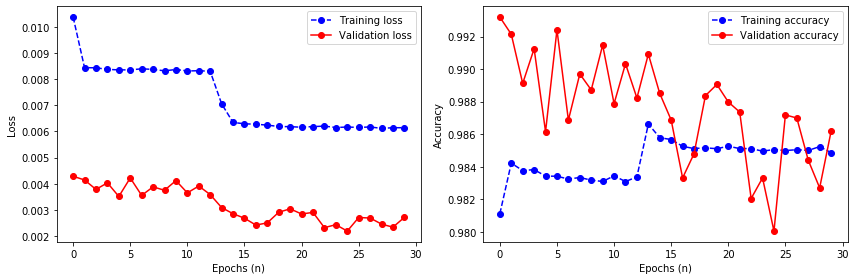

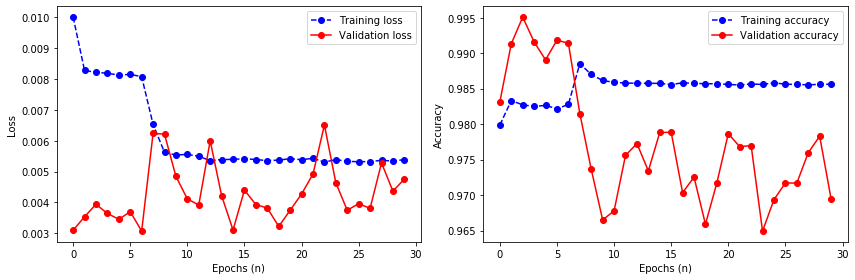

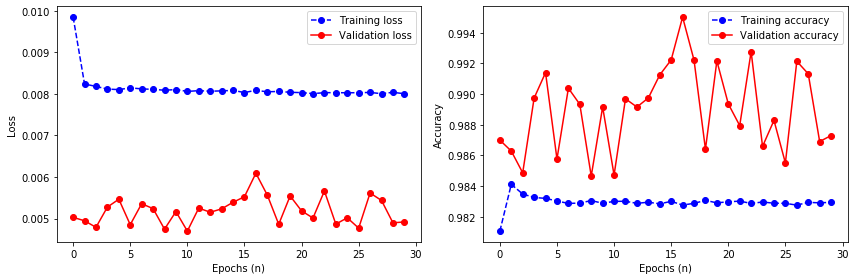

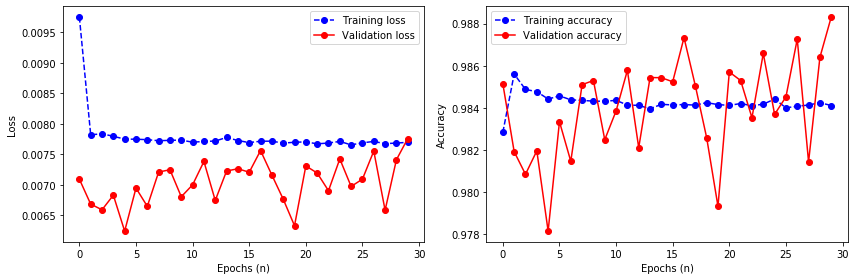

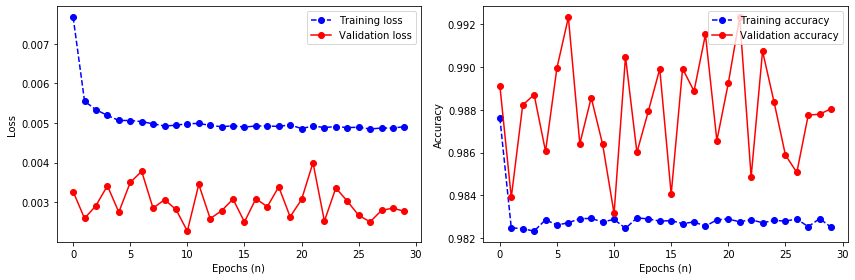

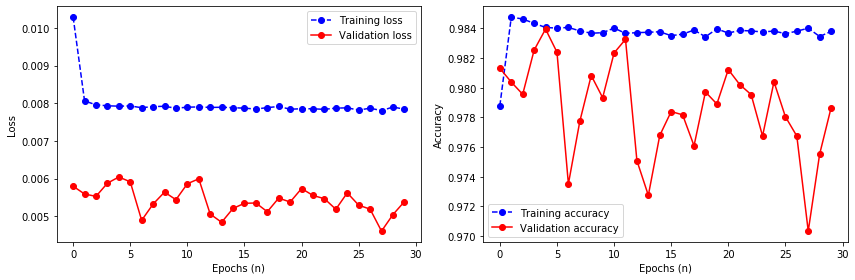

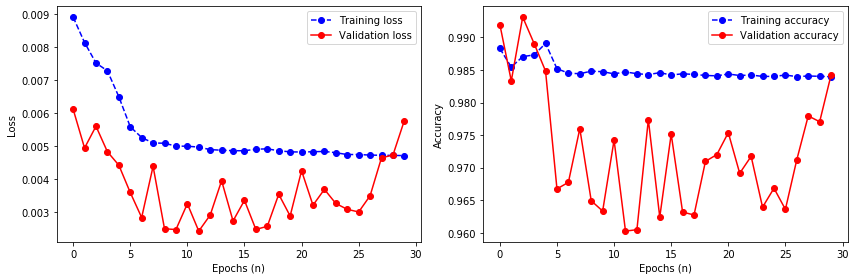

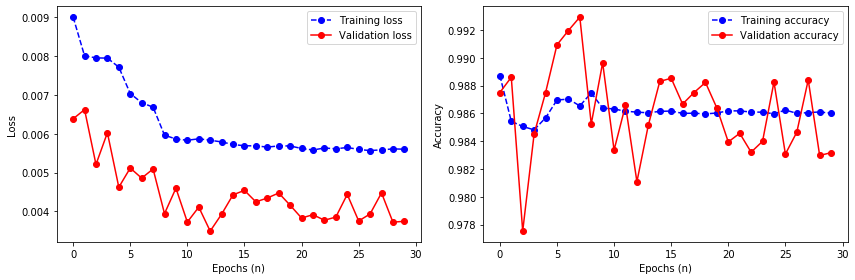

In [8]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()
print("Training started at: {}".format(time_sequence_start))
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))

val_aurocs          = np.zeros(n_files)
val_best_thresholds = np.zeros(n_files)
val_best_tp         = np.zeros(n_files)
val_best_fp         = np.zeros(n_files)

test_aurocs          = np.zeros(n_files)
test_best_thresholds = np.zeros(n_files)
test_best_tp         = np.zeros(n_files)
test_best_fp         = np.zeros(n_files)


for i in range(n_files):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    train_segmentation_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    
    val_ultrasound_data = ultrasound_arrays[i]
    val_segmentation_data = segmentation_arrays[i]
    val_ultrasound_filename = training_ultrasound_filenames[i]
    
    for train_index in range(n_files):
        if train_index != i:
            train_ultrasound_data = np.concatenate((train_ultrasound_data, ultrasound_arrays[train_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data, segmentation_arrays[train_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("")
    print("Training on {} images, validating on {} images.".format(n_train, n_val))
    
    # Create and train model
    
    model = unet.sagittal_spine_unet(ultrasound_size, num_classes, regularization_rate)
    
    model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
              loss=[unet.weighted_categorical_crossentropy(WCE_weights)],
              metrics=["accuracy", unet.dice_coef])
    
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor
    )
    
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(training_generator,
                                       validation_data=(val_ultrasound_data, val_segmentation_data),
                                       epochs=num_epochs,
                                       verbose=0)
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("Metrics at the end of training")
    print("  val_acc:  ", training_log.history['val_acc'][-1])
    print("  val loss: ", training_log.history['val_loss'][-1])
    print("  val_dice: ", training_log.history['val_dice_coef'][-1])
    print("  Total training time: {}\n".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['acc'], 'bo--')
    axes[1].plot(training_log.history['val_acc'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on validation and test data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    y_pred_test = model.predict(test_ultrasound_array)
    
    # Saving L-1-O prediction for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = filename_noext + "_prediction.npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    np.save(val_prediction_fullname, y_pred_val)
    print("Validation predictions saved to: {}".format(val_prediction_fullname))

    # Saving test prediction for further evaluation
    
    test_prediction_filename = "prediction-test.npy"
    test_prediction_fullname = os.path.join(test_data_fullpath, test_prediction_filename)
    np.save(test_prediction_fullname, y_pred_test)
    print("Testing predictions saved to:    {}".format(test_prediction_fullname))
    
    # Archive trained model with unique filename based on timestamps
    
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
    model_file_name = this_notebook_name + "_model_" + timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    print("Model saved to: {}".format(model_fullname))
    
    # Validation output
    
    true_positives, false_positives, best_threshold_index, area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_aurocs[i] = area
    val_best_thresholds[i] = roc_thresholds[best_threshold_index]
    val_best_tp[i] = true_positives[best_threshold_index]
    val_best_fp[i] = false_positives[best_threshold_index]
    
    # Test the model
    
    true_positives, false_positives, best_threshold_index, area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_test, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_aurocs[i] = area
    test_best_thresholds[i] = roc_thresholds[best_threshold_index]
    test_best_tp[i] = true_positives[best_threshold_index]
    test_best_fp[i] = false_positives[best_threshold_index]
    
    print("")
    print("Validation AUROC: {}".format(val_aurocs[i]))
    print("Test AUROC:       {}".format(test_aurocs[i]))


time_sequence_stop = datetime.datetime.now()

print("\nAll training stopped at: {}".format(time_sequence_stop))
print("\nTotal training time:        {}".format(time_sequence_stop - time_sequence_start))


In [9]:
# Output for Excel sheet

print("\nValidation AUROCS")
for i in range(n_files):
    print(test_aurocs[i])

print("\nValidation best thresholds")
for i in range(n_files):
    print(test_best_thresholds[i])
    
print("\nValidation true positives")
for i in range(n_files):
    print(test_best_tp[i])

print("\nValidation false positives")
for i in range(n_files):
    print(test_best_fp[i])

    
print("\nTest AUROCS")
for i in range(n_files):
    print(val_aurocs[i])

print("\nTest best thresholds")
for i in range(n_files):
    print(val_best_thresholds[i])
    
print("\nTest true positives")
for i in range(n_files):
    print(val_best_tp[i])

print("\nTest false positives")
for i in range(n_files):
    print(val_best_fp[i])


Validation AUROCS
0.9582655767762762
0.9584401585146145
0.9190971760551607
0.9212634119128091
0.9703033234886403
0.9197542587788866
0.9595021985566312
0.9503238403126566

Validation best thresholds
0.6
0.6
0.4
0.3
0.4
0.4
0.4
0.7

Validation true positives
0.94915135608049
0.9375561388159813
0.9537007874015748
0.9545056867891514
0.9740449110527851
0.9468883056284632
0.9259025955088948
0.9563721201516477

Validation false positives
0.0907350681551668
0.0842320731918123
0.168815512339864
0.16911715119022147
0.08870151173321289
0.16187846753710403
0.08550603428536363
0.09254668533482117

Test AUROCS
0.9626714721495114
0.8441129855937026
0.9011688366802229
0.8982679453660644
0.9726834972644253
0.8964782523334156
0.9563046243915649
0.966616066219927

Test best thresholds
0.06
0.01
0.04
0.04
0.04
0.06
0.02
0.08

Test true positives
0.9507567860567903
0.9785042236110157
0.9653991549922171
0.9380432958550092
0.9479014746394425
0.949237683969331
0.8978569997997196
0.9632552895138289

Test fals

In [10]:
shift = np.random.randint(-max_shift_factor * 128,
                          max_shift_factor * 128,
                          (2))
print(shift)

[0 0]


In [11]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [12]:
# Export HTML copy of this notebook

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

notebook_file_name = this_notebook_name + "_" + timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: d:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationStudy_2019-10-20_01-59-39.html
